In [1]:
import numpy as np 
import random
import bisect
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import math

In [2]:
def pretty_matrix_print(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            print(round(matrix[i][j], 5), end=" ")
        print("")

In [3]:
def readJSSP(path):
    with open(path, 'r') as f:
        lines =  f.readlines()
        jobs = [[(int(machine), int(cost)) for machine, cost in zip(line.split()[0::2], line.split()[1::2])]
                for line in lines[1:] if line.strip()]
        
        return jobs

In [4]:
def calcMakespan(jobs, schedule):
    n = len(jobs)
    m = len(jobs[0])
    
    job_end = np.zeros(n, dtype=np.int) # end of prev. tasks for each job 
    machine_end = np.zeros(m, dtype=np.int) # end of prev. task for each machine
    next_task = np.zeros(n, dtype=np.int) # next task for each job
    
    
    for job in schedule:
        machine, cost = jobs[job][next_task[job]]
        
        job_start = max(machine_end[machine], job_end[job])
        
        job_end[job] = job_start + cost
        machine_end[machine] = job_start + cost
        
        next_task[job] += 1
        
    return max(machine_end)

In [5]:
def convert_tour_to_schedule(m, tour):
    return list(map(lambda x: x // m, tour))

In [6]:
def convert_schedule_to_tour(n, m, schedule):
    op_counter = [0 for _ in range(n)]
    tour = []
    #print(schedule)
    for job in schedule:
        #print(job*m + op_counter[job])
        tour.append(job*m + op_counter[job])
        op_counter[job] += 1
        
    return tour

In [7]:
def randomSolution(jobs, num_iter):
    n, m = len(jobs), len(jobs[0])
    best_tour = []
    best_makespan = 999999
    
    
    for _ in range(num_iter):
        solution = [j for j in range(n) for i in range(m)]
        random.shuffle(solution)
        makespan = calcMakespan(jobs, solution)
        
        # convert schedule to tour
        tour = convert_schedule_to_tour(n, m, solution)
        if(makespan < best_makespan):
            best_tour = tour
            best_makespan = makespan
    return best_tour, best_makespan

In [9]:
def get_probability(jobs, av_nodes, curr_node, pheromones, alpha, beta, rule):
    n, m = len(jobs), len(jobs[0])
    
    if(rule == "SRT"):
        beta *= -1
        
    p = [(pheromones[curr_node][node] ** alpha) * ((jobs[node // m][node % m][1]) ** beta) for node in av_nodes]
    s = sum(p)
    p = [x / s for x in p]
    return p

In [98]:
def optimize(jobs, C, alpha, beta, rho, tau_0, e, Q):
    n, m = len(jobs), len(jobs[0])
    
    k = n // 2 # number of Ants
    pheromones = [[tau_0 for j in range(n * m)] for i in range(n * m)]
    delta_pheromones = [[0 for j in range(n * m)] for i in range(n * m)]
    best_makespan = 99999999
    best_tour = []
    
    best_tour_on_cycles = []
    best_makespan_on_cycles = []
    
    for it in tqdm(range(C)):
        av_nodes = [[j * m for j in range(n)] for i in range(k)]
        tours = [[] for i in range(k)]
        
        # decidability rule 
        # Longest processing time
        # Shortest processing time
        #rule = random.choice(["LRT", "SRT"])
        rule = random.choice(["LRT"])
        # randmoly assign firts operation 
        for i in range(k):
            next_node = random.choice(av_nodes[i])
            av_nodes[i].remove(next_node)
            av_nodes[i].append(next_node + 1)
            tours[i].append(next_node)
        
        # create tours 
        for _ in range(n * m - 1):
            for i in range(k):
                p = get_probability(jobs, av_nodes[i], tours[i][-1], pheromones, alpha, beta, rule)
                
                prob_cumm = 0
                q = random.random()
                s=len(av_nodes) - 1
                for p_i, x in enumerate(p):        
                    prob_cumm += x
                    if(q < prob_cumm):
                        s = p_i
                        break
                #print(i, len(tours[i]), av_nodes[i], s)    
                next_node = av_nodes[i][min(s, len(av_nodes[i]) - 1)]
                
                tours[i].append(next_node)
                av_nodes[i].remove(next_node)
                if((next_node + 1) % m != 0):
                    av_nodes[i].append(next_node + 1)
                #print(i, next_node, av_nodes[i])    
        
        # calculate results 
        makespans = [calcMakespan(jobs, convert_tour_to_schedule(m, tour)) for tour in tours]
        
        best_makespan_on_cycles.append(min(makespans))
        best_tour_on_cycles.append(tours[makespans.index(min(makespans))])
        
        if(best_makespan > best_makespan_on_cycles[-1]):
            best_makespan = best_makespan_on_cycles[-1]
            best_tour = best_tour_on_cycles[-1]
        
        # calculate delta pheromones 
        for tour in tours:
            makespan = calcMakespan(jobs, convert_tour_to_schedule(m, tour))
            if (makespan == best_makespan_on_cycles[-1]):
                for i in range(1, len(tour)):
                    delta_pheromones[tour[i-1]][tour[i]] = Q * e / makespan
            else:
                for i in range(1, len(tour)):
                    delta_pheromones[tour[i-1]][tour[i]] = Q / makespan
                    
        # update pheromones 
        for i in range(n * m):
            for j in range(n * m):
                pheromones[i][j] = delta_pheromones[i][j] + rho * pheromones[i][j]
                delta_pheromones[i][j] = 0
    return best_makespan, best_tour, best_tour_on_cycles, best_makespan_on_cycles

In [118]:
jobs = readJSSP("./instanses/la01")
C = 1000
alpha = 0.2
beta = 0.8
rho = 0.7
tau_0 = 0.00005
e = 5
Q = 2


best_makespan, best_tour, best_tour_on_cycles, best_makespane_on_cycles = optimize(jobs, C, alpha, beta, rho, tau_0, e, Q)
best_makespan

937

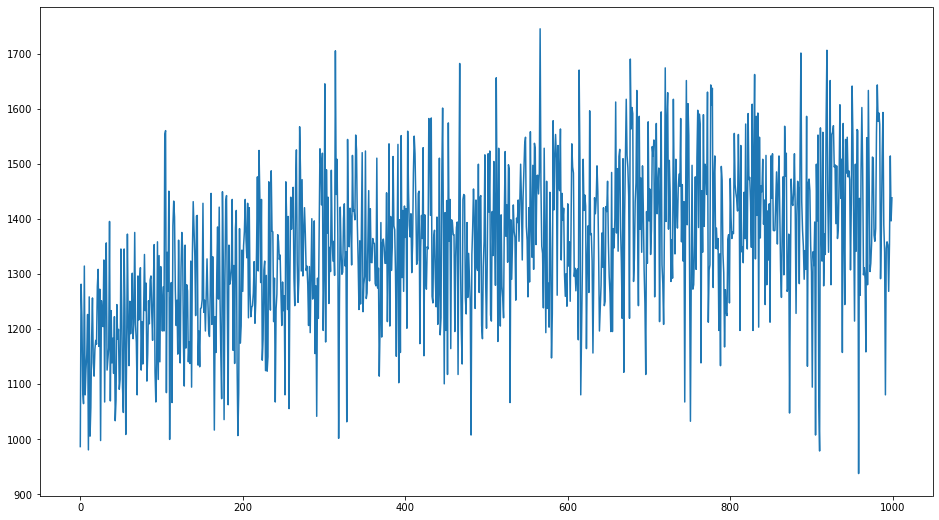

In [119]:
x = [i for i in range(len(best_makespane_on_cycles))]


plt.figure(figsize=(16, 9))
plt.plot(x, best_makespane_on_cycles)